In [1]:
import daspi as dsp
DPI = 120
dsp.__version__

'0.5.0'

In [2]:
import pandas as pd
import daspi as dsp
df = dsp.load_dataset('aspirin-dissolution')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee     48 non-null     object 
 1   stirrer      48 non-null     object 
 2   brand        48 non-null     object 
 3   catalyst     48 non-null     bool   
 4   water        48 non-null     object 
 5   temperature  48 non-null     float64
 6   preparation  48 non-null     float64
 7   dissolution  48 non-null     float64
 8   time         48 non-null     float64
dtypes: bool(1), float64(4), object(4)
memory usage: 3.2+ KB


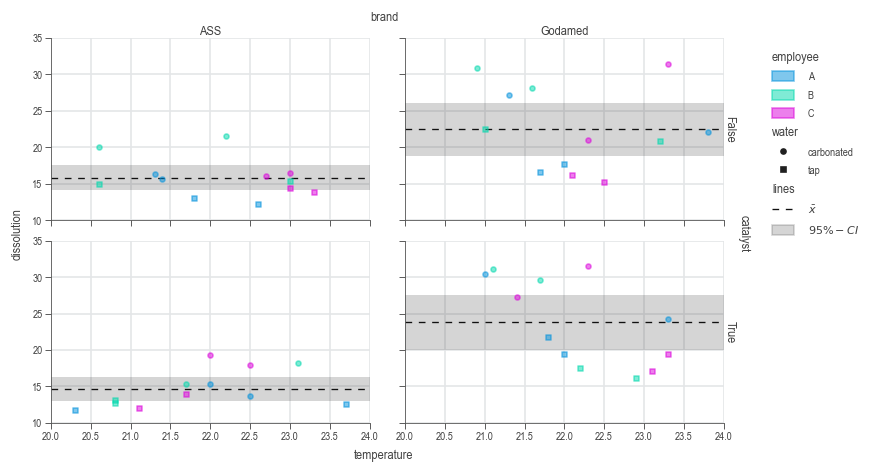

In [3]:
chart = dsp.MultipleVariateChart(
        source=df,
        target='dissolution',
        feature='temperature',
        hue='employee',
        shape='water',
        col='brand',
        row='catalyst',
        stretch_figsize=False
    ).plot(
        dsp.Scatter
    ).stripes(
        mean=True,
        confidence=0.95
    ).label(
        feature_label=True,
        target_label=True
    )

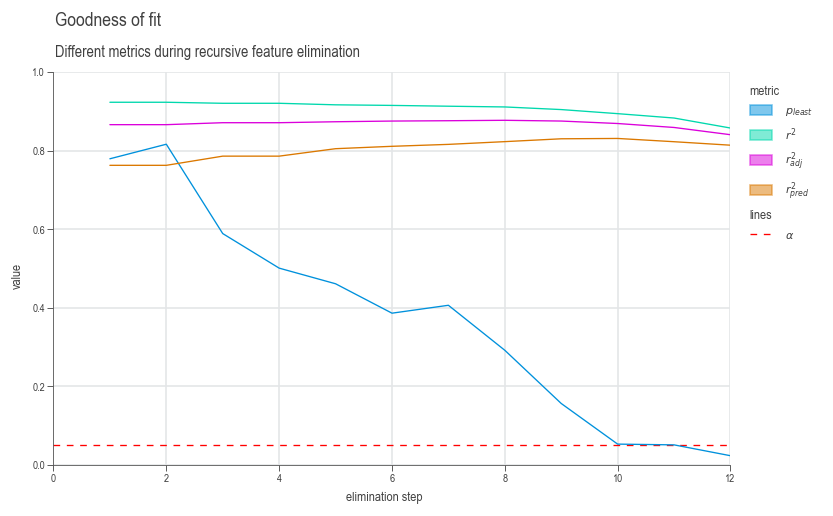

In [ ]:
ALPHA = 0.05
model = dsp.LinearModel(
    source=df,
    target='dissolution',
    categorical=[
        'employee',
        'stirrer',
        'brand',
        'catalyst',
        'water'],
    continuous=['temperature'],
    alpha=ALPHA,
    order=2)

goodness_of_fit_gen = model.recursive_feature_elimination()
df_gof = pd.concat(goodness_of_fit_gen)

# rename columns for mathematical notation
columns_map = {
    'p_least': '$p_{least}$',
    'r2': '$r^2$',
    'r2_adj': '$r^2_{adj}$',
    'r2_pred': '$r^2_{pred}$'}
data = df_gof.rename(columns=columns_map)
 reshape into long format
data = pd.melt(
    data, value_vars=columns_map.values(), var_name='metric')

chart = dsp.SingleChart(
        source=data,
        target='value',
        hue='metric'
    ).plot(
        dsp.Line
    ).stripes(
        stripes=[dsp.StripeLine(r'\alpha', ALPHA, color='red')]
    ).label(
        fig_title='Goodness of fit',
        sub_title='Different metrics during recursive feature elimination',
        target_label=True,
        feature_label='elimination step'
    )
_ = chart.axes[0, 0].set(ylim=(0, 1))

formula:
dissolution ~ 16.0792 + 2.3750*employee[T.B] + 0.8375*employee[T.C] + 10.7500*brand[T.Godamed] - 3.8000*water[T.tap] - 5.7167*brand[T.Godamed]:water[T.tap]

Model summary:
   hierarchical least_term   p_least         s         aic        r2  r2_adj  \
0          True   employee  0.023298  2.374693  224.835935  0.857379  0.8404   

    r2_pred  
0  0.813719  

Parameter statistics:
                                    coef   std err          t             p  \
Intercept                      16.079167  0.839581  19.151424  2.275979e-22   
employee[T.B]                   2.375000  0.839581   2.828793  7.132978e-03   
employee[T.C]                   0.837500  0.839581   0.997522  3.242240e-01   
brand[T.Godamed]               10.750000  0.969464  11.088598  4.695450e-14   
water[T.tap]                   -3.800000  0.969464  -3.919690  3.212100e-04   
brand[T.Godamed]:water[T.tap]  -5.716667  1.371030  -4.169616  1.493044e-04   

                                  ci_low     ci_upp  
Intercept                      14.384824  17.773509  
employee[T.B]                   0.680657   4.069343  
employee[T.C]                  -0.856843   2.531843  
brand[T.Godamed]                8.793542  12.706458  
water[T.tap]                   -5.756458  -1.843542  
brand[T.Godamed]:water[T.tap]  -8.483516  -2.949817  

Analysis of variance:
Typ-I        DF          SS          MS           F             p        n2
Source                                                                     
employee      2   46.431667   23.215833    4.116891  2.329817e-02  0.027960
brand         1  747.340833  747.340833  132.526821  1.424173e-14  0.450027
water         1  532.000833  532.000833   94.340328  2.657815e-12  0.320355
brand:water   1   98.040833   98.040833   17.385695  1.493044e-04  0.059037
Residual     42  236.845000    5.639167         NaN           NaN  0.142621

Variance inflation factor:
             DF  VIF      GVIF  Threshold  Collinear               Method
Intercept     1  5.0  2.236068   2.236068       True            R_squared
employee      2  1.0       1.0   1.495349      False          generalized
brand         1  1.0       1.0   2.236068      False            R_squared
water         1  1.0       1.0   2.236068      False            R_squared
brand:water   1  1.0       1.0   2.236068      False  single_order-2_term

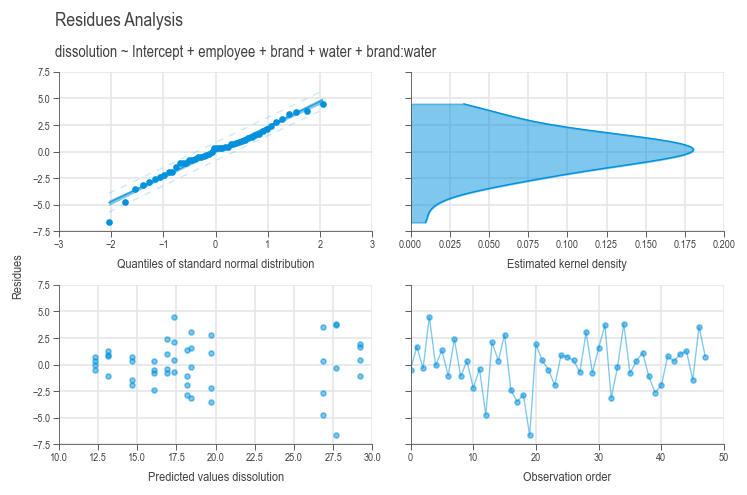

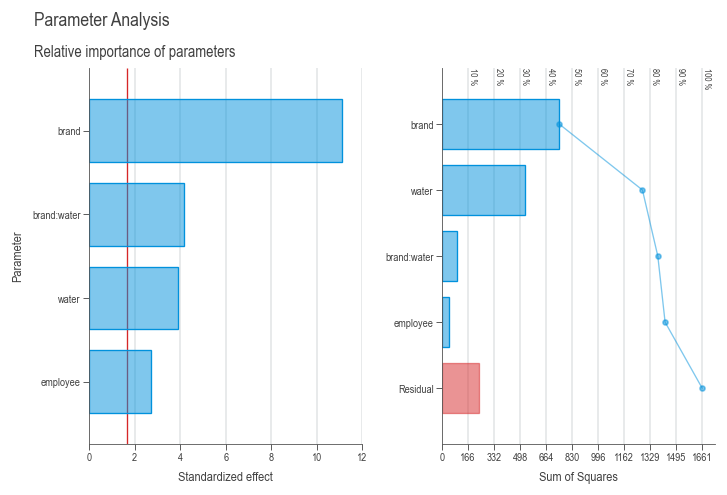

In [5]:
dsp.ResidualsCharts(model).plot().label()
dsp.ParameterRelevanceCharts(model).plot().label()
model

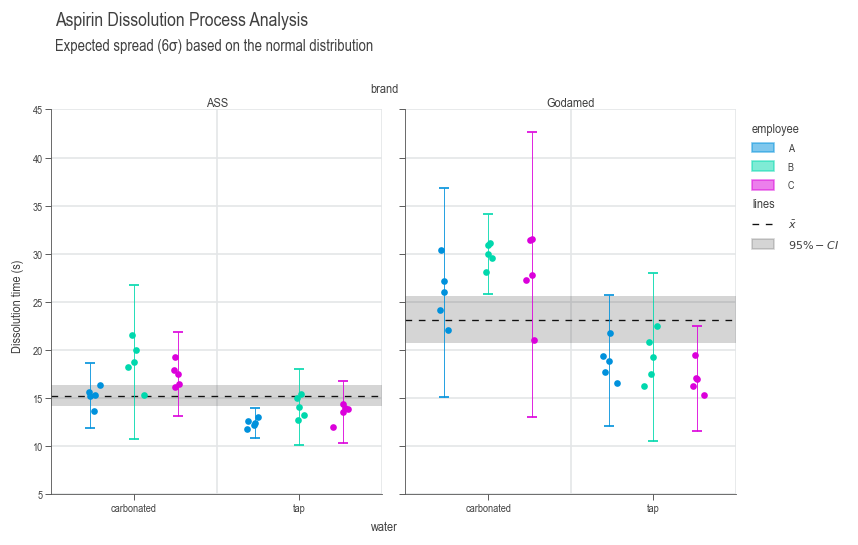

In [6]:
chart = dsp.MultipleVariateChart(
        source=df,
        target='dissolution',
        feature='water',
        col='brand',
        hue='employee',
        dodge=True,
    ).plot(
        dsp.Jitter
    ).plot(
        dsp.SpreadWidth,
        agreement=6,
        strategy='norm',
        bars_same_color=True
    ).stripes(
        mean=True,
        confidence=0.95
    ).label(
        fig_title='Aspirin Dissolution Process Analysis',
        sub_title='Expected spread (6σ) based on the normal distribution',
        feature_label=True,
        target_label='Dissolution time (s)'
    )

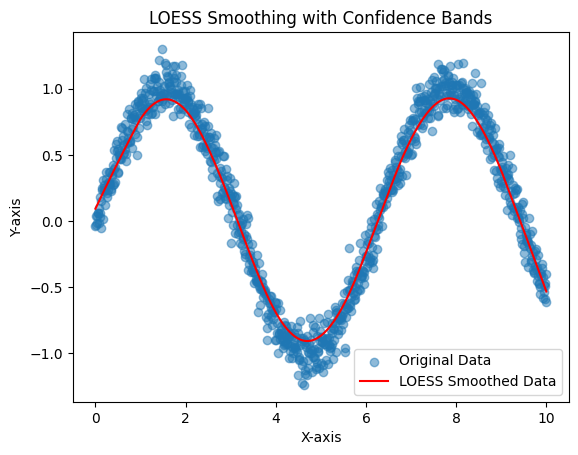

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

def ppoints(n):
    """
    Generate points for plotting based on the empirical distribution.
    
    Parameters:
    - n: int, the number of points
    
    Returns:
    - points: numpy array, the generated points
    """
    return (np.arange(1, n + 1) - 0.5) / n

def loess_smooth(x, y, frac=0.2, xvals=None):
    """
    Smooth the data using LOESS.
    
    Parameters:
    - x: array-like, the x values of the data
    - y: array-like, the y values of the data
    - frac: float, the fraction of the data used for each local regression
    
    Returns:
    - smoothed_y: numpy array, the smoothed y values
    """
    # Perform LOESS smoothing
    lowess = sm.nonparametric.lowess(y, x, frac=frac, xvals=xvals)
    if xvals is not None:
        smoothed_y = lowess
    else:
        smoothed_y = lowess[:, 1]  # Extract the smoothed values
    return smoothed_y

def calculate_confidence_bands(x, y, smoothed_y):
    """
    Calculate confidence bands for the LOESS smoothed data.
    
    Parameters:
    - x: array-like, the x values of the data
    - y: array-like, the y values of the data
    - smoothed_y: numpy array, the smoothed y values
    
    Returns:
    - lower_band: numpy array, the lower confidence band
    - upper_band: numpy array, the upper confidence band
    """
    # Calculate residuals
    residuals = y - smoothed_y

    # Define n as the length of the data
    n = len(y)

    # Calculate the empirical quantiles for the confidence bands
    p = ppoints(n)
    quantiles = np.percentile(residuals, 100 * p)

    # Calculate lower and upper confidence bands
    lower_band = smoothed_y + quantiles[0]  # Lower bound
    upper_band = smoothed_y + quantiles[-1]  # Upper bound
    
    return lower_band, upper_band

# Sample data
x = np.linspace(0, 10, 1000)
y = np.sin(x) + np.random.normal(0, 0.1, size=x.shape)

# Smooth the data using LOESS
_x = None#np.linspace(x.min(), x.max(), 1000)
smoothed_y = loess_smooth(x, y, frac=0.2, xvals=_x)

# Calculate confidence bands
# lower_band, upper_band = calculate_confidence_bands(x, y, smoothed_y)

# Plotting
plt.scatter(x, y, label='Original Data', alpha=0.5)
if _x is not None:
    plt.plot(_x, smoothed_y, label='LOESS Smoothed Data', color='red')
else:
    plt.plot(x, smoothed_y, label='LOESS Smoothed Data', color='red')
# plt.fill_between(x, lower_band, upper_band, color='red', alpha=0.2, label='Confidence Band')

plt.legend()
plt.title('LOESS Smoothing with Confidence Bands')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

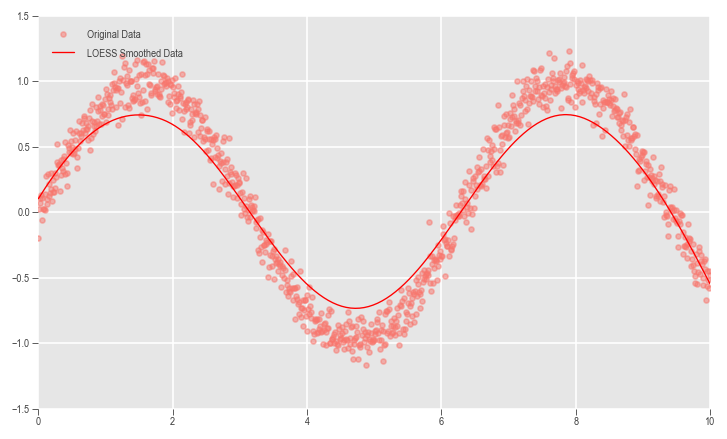

In [1]:
import numpy as np
import daspi as dsp
import pandas as pd
import matplotlib.pyplot as plt

dsp.use_style('ggplot2')
x = np.linspace(0, 10, 1000)
data = pd.DataFrame(dict(
    x = x,
    y = np.sin(x) + np.random.normal(0, 0.1, size=x.shape)))
model = dsp.Lowess(data, 'y', 'x').fit(0.2)

sequence, prediction = model.predict_sequence()
plt.scatter(data.x, data.y, label='Original Data', alpha=0.5)
plt.plot(sequence, prediction, label='LOESS Smoothed Data', color='red')
plt.legend()

In [27]:
import daspi as dsp
dsp.STYLES

('daspi',
 'daspi_dark',
 'ggplot2',
 'Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'festo',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10')